In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon April 29 13:25:11 2020

@author: rfuchs
"""

import os 

%matplotlib inline
import pandas as pd
from copy import deepcopy
from gower import gower_matrix
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder 

from MIAMI import MIAMI
from init_params import dim_reduce_init
from data_preprocessing import compute_nj

from shapely.geometry import Polygon as polygon

import autograd.numpy as np

from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import pdist, squareform


In [2]:
res_folder = 'MIAMI/Results/Adult/'

if not os.path.exists(res_folder):
    os.makedirs(res_folder)
#===========================================#
# Model Hyper-parameters
#===========================================#

n_clusters = 4
r = np.array([2, 1])
k = [4]

seed = 1
init_seed = 2
    
# !!! Changed eps
eps = 1E-02
it = 4
maxstep = 100
        

var_distrib = np.array(['continuous', 'categorical', 'continuous',\
                        'ordinal', 'categorical', 'categorical', 'categorical',\
                        'categorical', 'bernoulli', 'ordinal', 'ordinal',\
                        'continuous', 'categorical', 'bernoulli']) 

# Plotting utilities
varnames = np.array(['age', 'workclass', 'fnlwgt',\
            'education.num', 'marital.status', 'occupation', 'relationship',\
            'race', 'sex', 'capital.gain', 'capital.loss',\
            'hours.per.week', 'native.country', 'income'])

    
dtypes_dict = {'continuous': float, 'categorical': str, 'ordinal': int,\
              'bernoulli': int, 'binomial': int}
    
    

#===========================================#
# Importing data
#===========================================#

inf_nb = 1E12
nb_pobs = 200


# acceptance_rate =
le_dict = {}

train_filepath = res_folder + 'adult.csv'


train = pd.read_csv(train_filepath, sep = ',')
train = train.infer_objects()



# Delete the missing values 
train = train.loc[~(train == '?').any(axis=1)]

NUMBER_OBSERVATIONS = 1000
train = train.iloc[:NUMBER_OBSERVATIONS, :]

numobs = len(train)
print("Running with", numobs, "observations!!!!")
# !!! Hack to remove
del(train['education'])
p = train.shape[1]

new_names_dict = dict(zip(train.columns, varnames))

train = train.rename(columns=new_names_dict)
train = train.reset_index(drop=True)

train_original = train.copy()


# Find the indices of the continuous features
continuous_indices = np.where(var_distrib == 'continuous')[0]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the continuous features
train.iloc[:, continuous_indices] = scaler.fit_transform(train.iloc[:, continuous_indices])


Running with 1000 observations!!!!


In [3]:
train_original

age  workclass  fnlwgt  education.num      marital.status   
0     25    Private  226802              7       Never-married  \
1     38    Private   89814              9  Married-civ-spouse   
2     28  Local-gov  336951             12  Married-civ-spouse   
3     44    Private  160323             10  Married-civ-spouse   
4     34    Private  198693              6       Never-married   
..   ...        ...     ...            ...                 ...   
995   81    Private  184615              4             Widowed   
996   28    Private  173858              9       Never-married   
997   28    Private  132326              9       Never-married   
998   43    Private  315037             13  Married-civ-spouse   
999   51    Private  175122              9  Married-civ-spouse   

            occupation    relationship                race     sex   
0    Machine-op-inspct       Own-child               Black    Male  \
1      Farming-fishing         Husband               White    Male   
2      Protective-serv         Husband               White    Male   
3    Machine-op-inspct         Husband               Black    Male   
4        Other-service   Not-in-family               White    Male   
..                 ...             ...                 ...     ...   
995  Machine-op-inspct       Unmarried               White  Female   
996       Craft-repair  Other-relative  Asian-Pac-Islander    Male   
997       Adm-clerical       Own-child               White    Male   
998       Craft-repair         Husband               White    Male   
999       Adm-clerical            Wife               White  Female   

     capital.gain  capital.loss  hours.per.week native.country income  
0               0             0              40  United-States  <=50K  
1               0             0              50  United-States  <=50K  
2               0             0              40  United-States   >50K  
3            7688             0              40  United-States   >50K  
4               0             0              30  United-States  <=50K  
..            ...           ...             ...            ...    ...  
995          1264             0              40  United-States  <=50K  
996             0             0              35          China  <=50K  
997             0             0              40  United-States  <=50K  
998             0             0              45  United-States   >50K  
999             0             0              40  United-States  <=50K  

[1000 rows x 14 columns]

In [4]:
# print(train["native.country"].value_counts())

In [5]:
#***************************************************************************
# Invert the order of the columns so that age is no more the first bernoulli
#***************************************************************************
'''
train[['age', 'workclass', 'fnlwgt', 'education.num', 'marital.status',
        'occupation', 'relationship', 'race', 'capital.gain',
        'capital.loss', 'hours.per.week', 'native.country', 'income', 'sex']]


var_distrib = np.array(['continuous', 'categorical', 'continuous',\
            'ordinal', 'categorical', 'categorical', 'categorical',\
            'categorical', 'ordinal', 'ordinal',\
            'continuous', 'categorical', 'bernoulli', 'bernoulli']) 
'''
                    
p_new = len(var_distrib)
cat_features = np.logical_or(var_distrib == 'categorical', var_distrib == 'ordinal')


#*****************************************************************
# Formating the data
#*****************************************************************
                
# Encode categorical datas
for col_idx, colname in enumerate(train.columns):
    if var_distrib[col_idx] == 'categorical': 
        le = LabelEncoder()

        # Convert them into numerical values               
        train[colname] = le.fit_transform(train_original[colname])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)
        le_dict[colname] = deepcopy(le)

    
# Encode binary data
for col_idx, colname in enumerate(train.columns):
    le = LabelEncoder()

    if var_distrib[col_idx] == 'bernoulli': 
        train[colname] = le.fit_transform(train[colname])
        le_dict[colname] = deepcopy(le)

# Encode ordinal data, modalities have been sorted (at best)
            
ord_le = LabelEncoder()
train['education.num'] = ord_le.fit_transform(train['education.num'])
le_dict['education.num'] = deepcopy(ord_le)

# Encode capital.gain and capital.loss and capital.gain as ordinal variables
for col in ['capital.gain', 'capital.loss']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    le_dict[col] = deepcopy(le)

nj, nj_bin, nj_ord, nj_categ = compute_nj(train, var_distrib)
nb_cont = np.sum(var_distrib == 'continuous')        
        
# Feature category (cf)
dtype = {train.columns[j]: dtypes_dict[var_distrib[j]] for j in range(p)}

train = train.astype(dtype, copy=True)
numobs = len(train)

# print("Computing Gower")
# # Defining distances over the features
# dm = gower_matrix(train, cat_features = cat_features) 
# print("done")

{'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5}
{'Divorced': 0, 'Married-AF-spouse': 1, 'Married-civ-spouse': 2, 'Married-spouse-absent': 3, 'Never-married': 4, 'Separated': 5, 'Widowed': 6}
{'Adm-clerical': 0, 'Armed-Forces': 1, 'Craft-repair': 2, 'Exec-managerial': 3, 'Farming-fishing': 4, 'Handlers-cleaners': 5, 'Machine-op-inspct': 6, 'Other-service': 7, 'Priv-house-serv': 8, 'Prof-specialty': 9, 'Protective-serv': 10, 'Sales': 11, 'Tech-support': 12, 'Transport-moving': 13}
{'Husband': 0, 'Not-in-family': 1, 'Other-relative': 2, 'Own-child': 3, 'Unmarried': 4, 'Wife': 5}
{'Amer-Indian-Eskimo': 0, 'Asian-Pac-Islander': 1, 'Black': 2, 'Other': 3, 'White': 4}
{'Cambodia': 0, 'Canada': 1, 'China': 2, 'Columbia': 3, 'Cuba': 4, 'Dominican-Republic': 5, 'El-Salvador': 6, 'England': 7, 'Germany': 8, 'Guatemala': 9, 'Haiti': 10, 'India': 11, 'Ireland': 12, 'Italy': 13, 'Japan': 14, 'Laos': 15, 'Mexico': 16, 'Nicaragua': 17, 'Peru':

In [6]:
sub_design = "none"


In [7]:
#*****************************************************************
# Sampling rules
#*****************************************************************    
authorized_ranges = np.expand_dims(np.stack([[-np.inf,np.inf] for var in var_distrib]).T, 1)

if sub_design == 'bivariate':
    # Want to sample only women of more than 60 years old
    authorized_ranges[:,0, 0] = [60, 100]  # Of more than 60 years old

    # Keep only women
    sex_idx = np.argmax(varnames == 'sex')
    women_idx = np.argmax(le_dict['sex'].classes_ == 'Female')
    authorized_ranges[:,0, sex_idx] = [women_idx, women_idx] # Only women
    
elif sub_design == 'trivariate':
    # Want to sample only women of more than 60 years old that are widowed
    authorized_ranges[:,0, 0] = [60, 100]  # Of more than 60 years old
    
    # Keep only women
    sex_idx = np.argmax(varnames == 'sex')
    women_idx = np.argmax(le_dict['sex'].classes_ == 'Female')
    authorized_ranges[:,0, sex_idx] = [women_idx, women_idx] # Only women

    # Keep only widows
    marital_idx = np.argmax(varnames == 'marital.status')                
    widowed_idx = np.argmax(le_dict['marital.status'].classes_ == 'Widowed')
    authorized_ranges[:,0, marital_idx] = [widowed_idx, widowed_idx] # Only widowed
else:
    authorized_ranges = None


In [8]:
#*****************************************************************
# Run MIAMI
#*****************************************************************

print("Initialize dimensionality reduction")    
init, transformed_famd_data  = dim_reduce_init(train, n_clusters, k, r, nj, var_distrib, seed = None,\
                                use_famd=True)

print("Computing distance matrix")
# Defining distances over the features
# dm = gower_matrix(train, cat_features = cat_features) 

# Compute the pairwise distances between all elements in my_array
distances = pdist(transformed_famd_data)

# Convert the pairwise distances to a square matrix
dm = squareform(distances)

print("Training")
out = MIAMI(train, n_clusters, r, k, init, var_distrib, nj, authorized_ranges, nb_pobs, it,\
                eps, maxstep, seed, perform_selec = False, dm = dm, max_patience = 0)
print('MIAMI has kept one observation over', round(1 / out['share_kept_pseudo_obs']),\
        'observations generated')
    
acceptance_rate = out['share_kept_pseudo_obs']
print(acceptance_rate)
pred = pd.DataFrame(out['y_all'], columns = train.columns) 


Initialize dimensionality reduction
(1000, 2)
(17, 17)
(1000, 2)
(47, 47)


/home/panagiotou/Desktop/M1DGMM/bevel/linear_ordinal_regression.py:234: RuntimeWarning: divide by zero encountered in log
  return - 1.0 * np.sum(np.log(self.link(z_plus) - self.link(z_minus)))


(1000, 2)
(24, 24)
Computing distance matrix
Training
0


/home/panagiotou/Desktop/M1DGMM/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/panagiotou/Desktop/M1DGMM/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

[-21449.384022819533]
[-1]
MIAMI has kept one observation over 1 observations generated
0.9803921568627451


In [9]:
#================================================================
# Inverse transform the datasets
#================================================================

for j, colname in enumerate(train.columns):
    if colname in le_dict.keys():
        pred[colname] = le_dict[colname].inverse_transform(pred[colname].astype(int))
    
pred.loc[:, var_distrib == 'continuous'] = pred.loc[:, var_distrib == 'continuous'].round(0)

print("Saved to", res_folder + 'preds.csv')
# Store the predictions
pred.to_csv(res_folder + 'preds.csv', index = False)
#break

Saved to MIAMI/Results/Adult/preds.csv


In [10]:
print(out.keys())

dict_keys(['classes', 'best_z', 'Ez.y', 'best_k', 'best_r', 'best_w_s', 'lambda_bin', 'lambda_ord', 'lambda_categ', 'lambda_cont', 'eta', 'mu', 'sigma', 'psl_y', 'ps_y', 'psi', 'H', 'w_s', 'likelihood', 'silhouette', 'zz', 'y_all', 'share_kept_pseudo_obs'])


In [11]:
print(acceptance_rate)

0.9803921568627451


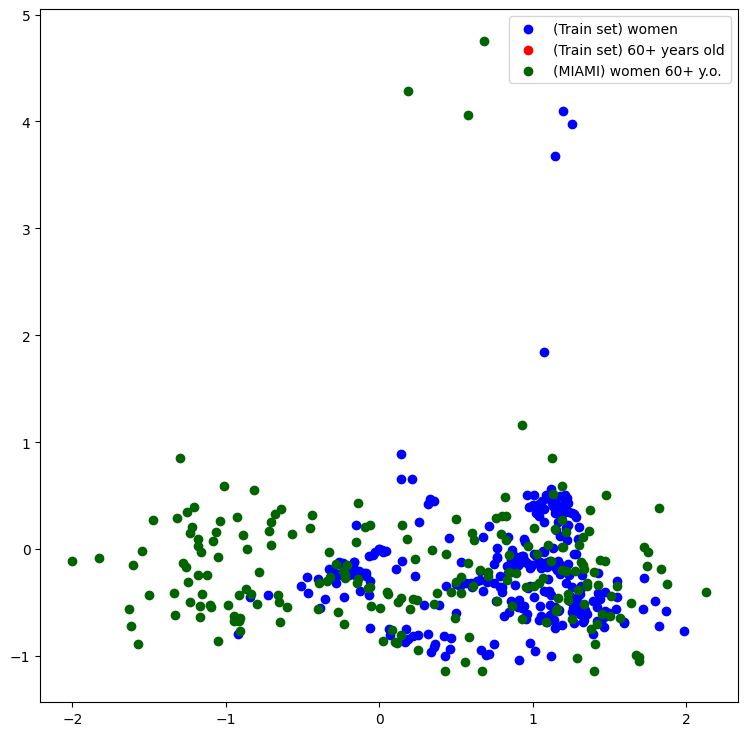

In [12]:
zz = out["zz"]

# z2 = np.vstack([zzz for zzz in zz if len(zzz) >0])
# plt.scatter(z2[:,0], z2[:,1])
# x1,y1 = polygon.exterior.coords.xy
# plt.plot(x1,y1)


# Compare woman, 60+ y.o and people presenting both modalities
zz = np.concatenate(out['zz'])

woman_idx = train['sex'] == 0
age_idx = train['age'] >= 60
bivariate_idx = woman_idx & age_idx

fig, ax = plt.subplots(figsize = (9, 9))
ax.scatter(out['Ez.y'][woman_idx,0], out['Ez.y'][woman_idx,1], c='blue', label = '(Train set) women')
ax.scatter(out['Ez.y'][age_idx,0], out['Ez.y'][age_idx,1], c='red', label = '(Train set) 60+ years old')
ax.scatter(zz[:,0], zz[:,1], c='darkgreen', label = '(MIAMI) women 60+ y.o.')
#plt.title('Latent representation of women and 60+ y.o. individuals from the train set and generated by MIAMI')
plt.legend()
plt.show()

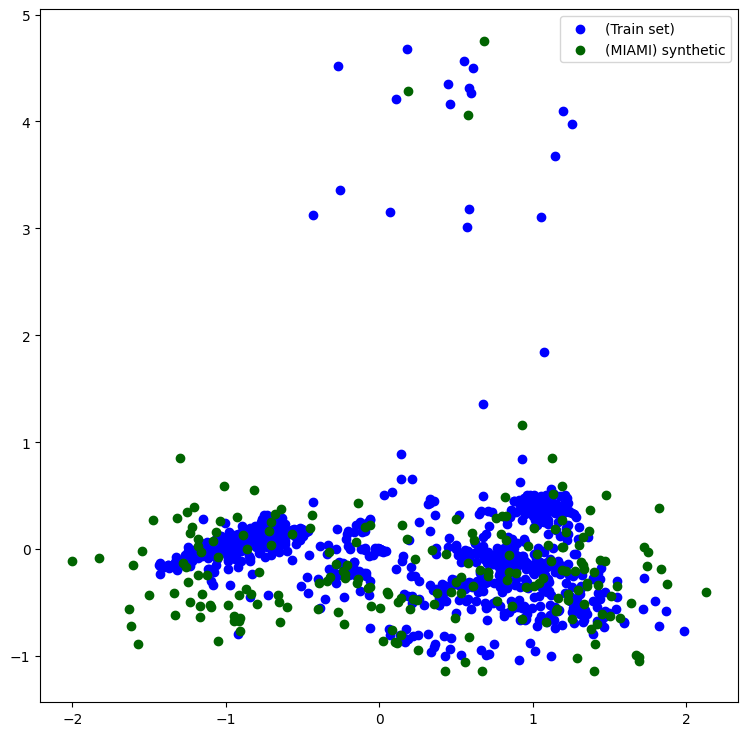

In [13]:
zz = out["zz"]

# z2 = np.vstack([zzz for zzz in zz if len(zzz) >0])
# plt.scatter(z2[:,0], z2[:,1])
# x1,y1 = polygon.exterior.coords.xy
# plt.plot(x1,y1)


# Compare woman, 60+ y.o and people presenting both modalities
zz = np.concatenate(out['zz'])


fig, ax = plt.subplots(figsize = (9, 9))
ax.scatter(out['Ez.y'][:,0], out['Ez.y'][:,1], c='blue', label = '(Train set)')
ax.scatter(zz[:,0], zz[:,1], c='darkgreen', label = '(MIAMI) synthetic')
#plt.title('Latent representation of women and 60+ y.o. individuals from the train set and generated by MIAMI')
plt.legend()
plt.show()

In [14]:
print(train.isnull().values.any())


False


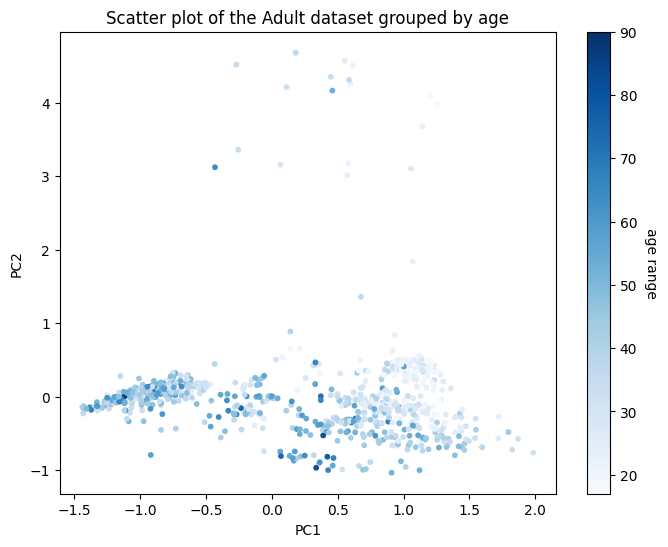

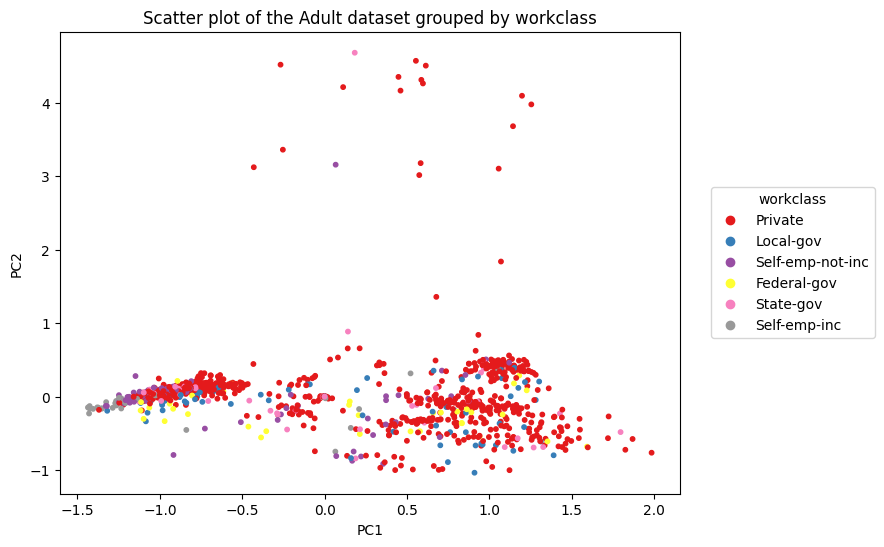

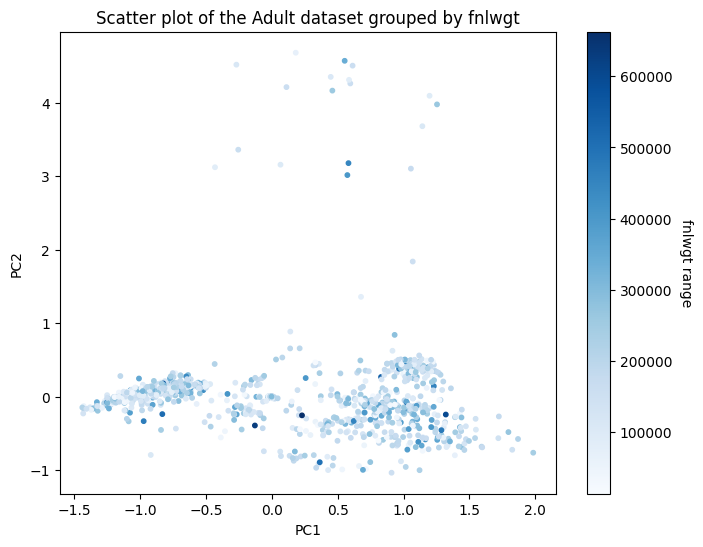

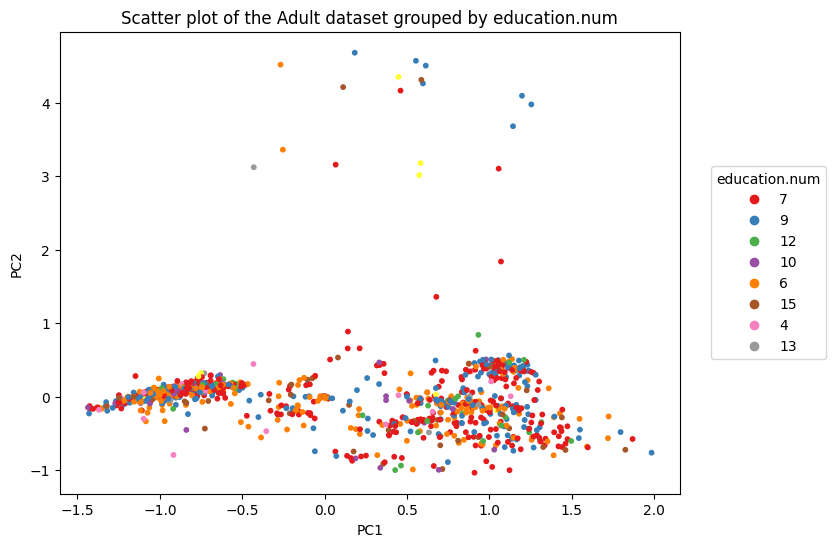

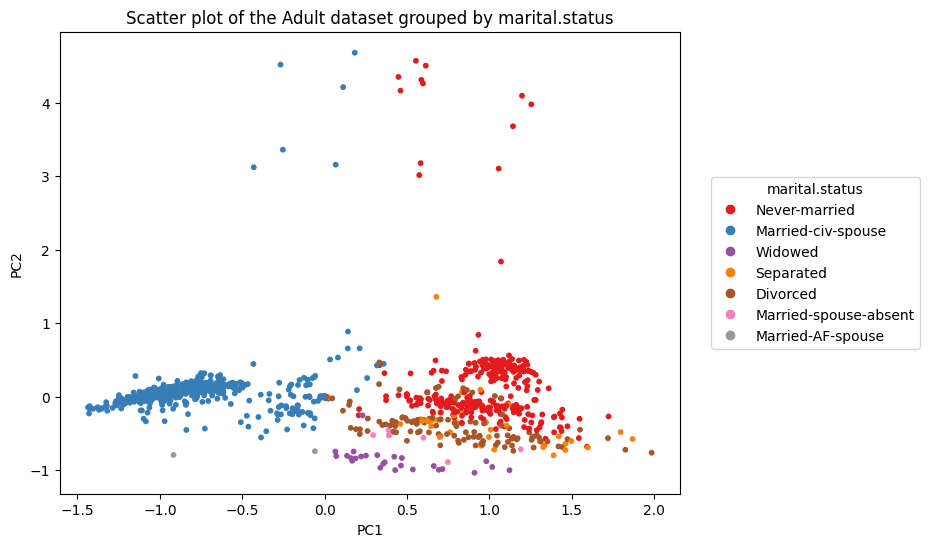

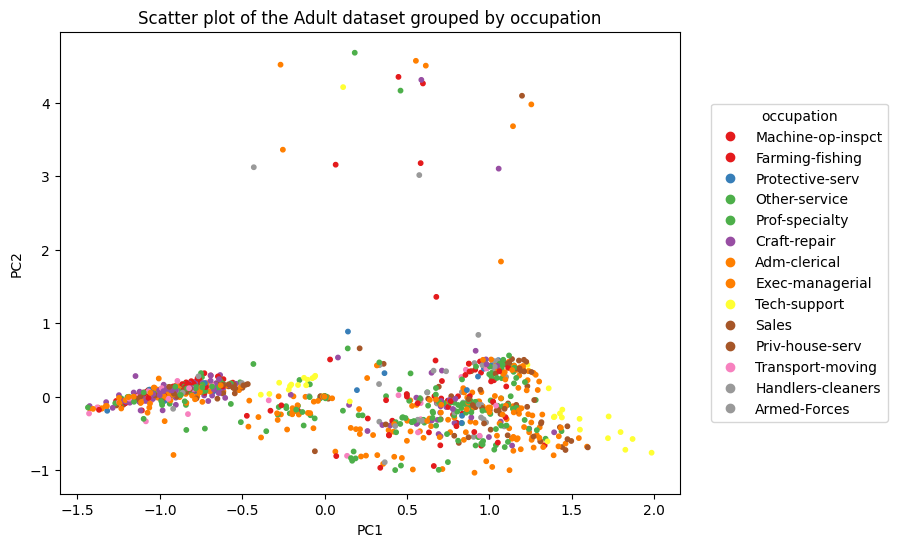

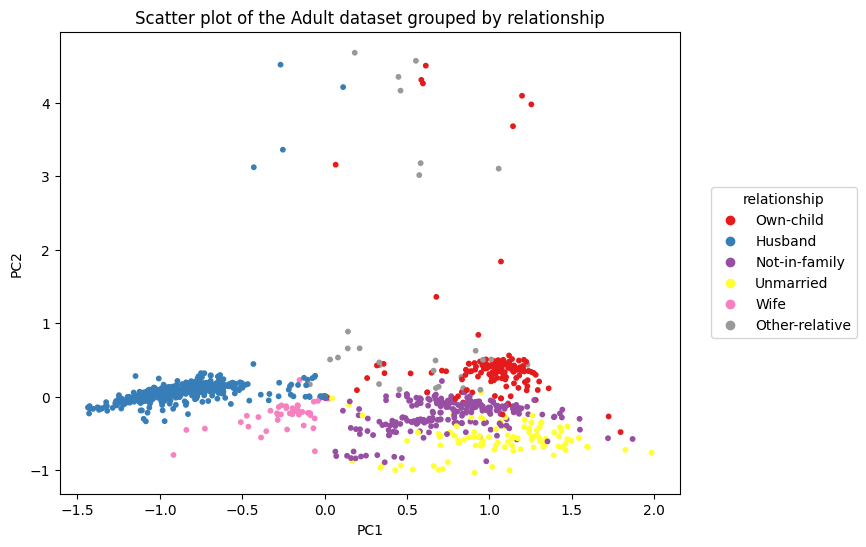

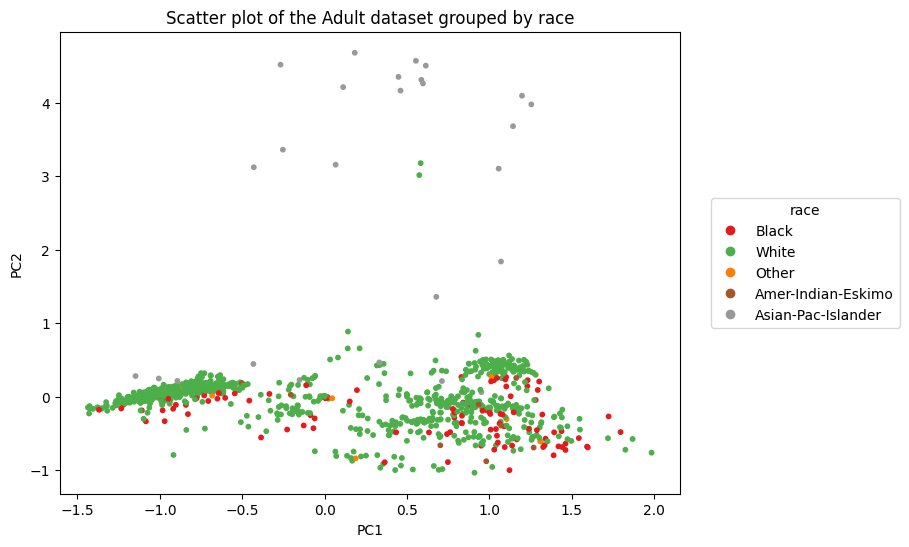

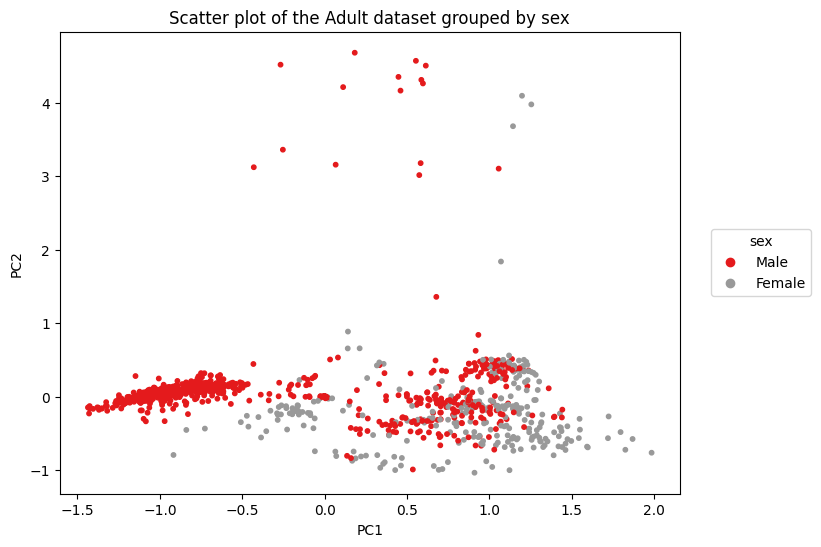

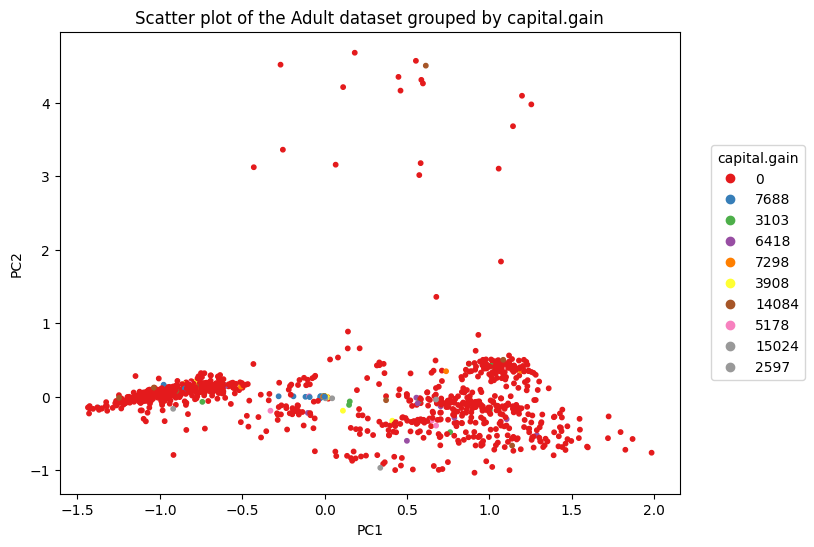

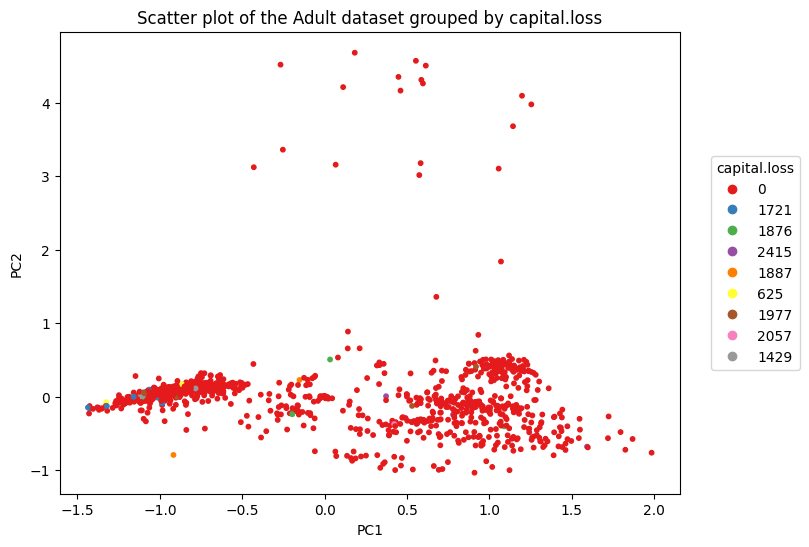

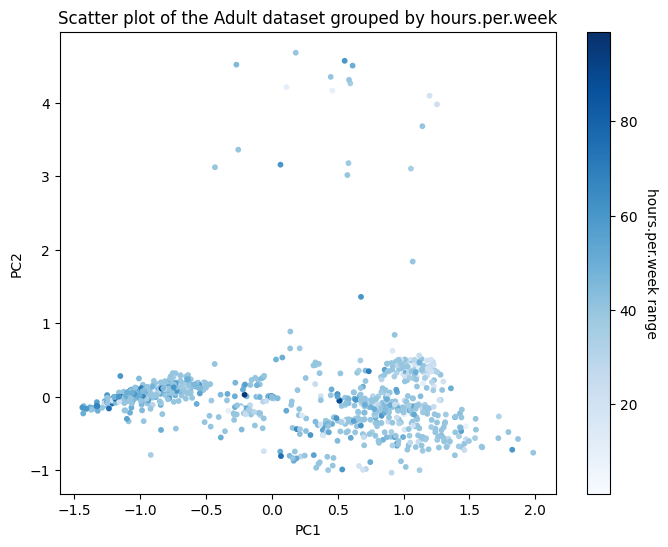

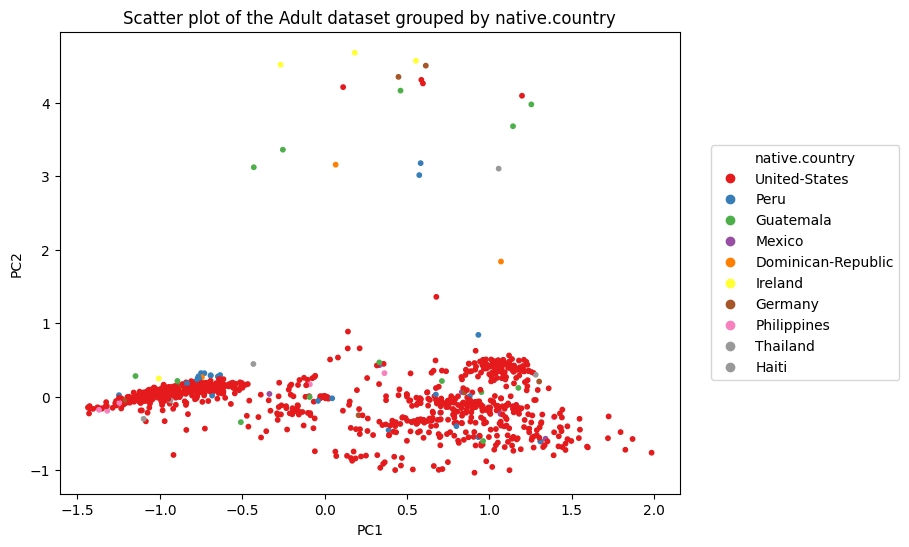

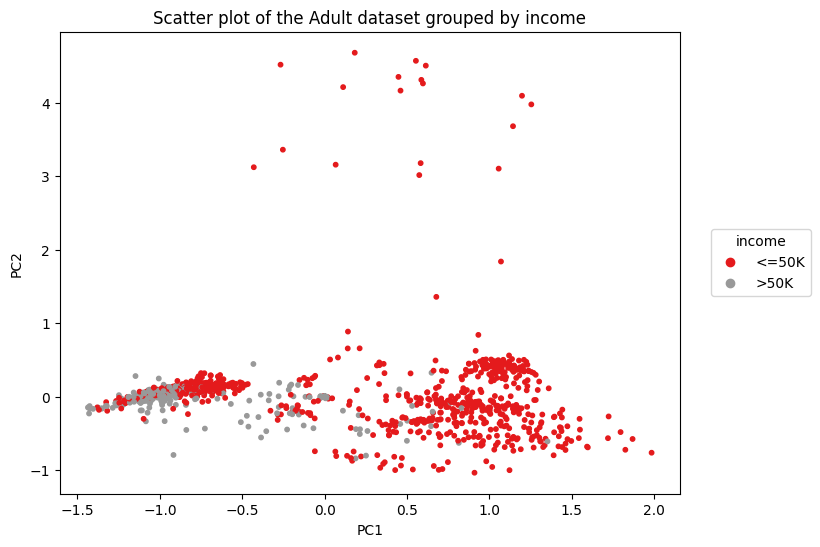

In [20]:
zz = out["zz"]

# z2 = np.vstack([zzz for zzz in zz if len(zzz) >0])
# plt.scatter(z2[:,0], z2[:,1])
# x1,y1 = polygon.exterior.coords.xy
# plt.plot(x1,y1)

df_scatter = pd.DataFrame()
df_scatter["x"] = out['Ez.y'][:,0]
df_scatter["y"] = out['Ez.y'][:,1]
continuous_position = 0

for col_idx, colname in enumerate(train.columns):
    if var_distrib[col_idx] in ['categorical', 'bernoulli', "ordinal"]: 
    #     feature = "race"
        # le_name_mapping = dict(zip(le_dict[feature].classes_, le_dict[feature].transform(le.classes_)))

        # print(le_name_mapping)
        # labels_real = le_dict[feature].inverse_transform(train_original[feature])
        unique_labels = le_dict[colname].classes_
        le_name_mapping = dict(zip(le_dict[colname].classes_, le_dict[colname].transform(le_dict[colname].classes_)))
#         print(le_name_mapping)
        # Compare woman, 60+ y.o and people presenting both modalities
        zz = np.concatenate(out['zz'])
        df_scatter["c"] = train[colname]
        df_scatter["label"] = train_original[colname]
        
        # Convert the labels to numeric values
        labels, levels = pd.factorize(df_scatter['label'])

        # Create a scatter plot
        fig, ax = plt.subplots(figsize=(8, 6))
        scatter = ax.scatter(x=df_scatter['x'], y=df_scatter['y'], c=labels, cmap='Set1', s=10)

        # Add a title and axis labels
        ax.set_title('Scatter plot of the Adult dataset grouped by ' + colname)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')

        # Create a legend
        handles, labels = scatter.legend_elements()
        legend = ax.legend(handles, levels, loc='center left', bbox_to_anchor=(1.05, 0.5), title=colname, borderaxespad=0.)

        plt.show()
    else:
        # Create a scatter plot
        fig, ax = plt.subplots(figsize=(8, 6))
        minn = scaler.data_min_[continuous_position]
        maxx = scaler.data_max_[continuous_position]
        
        scatter = ax.scatter(x=df_scatter['x'], y=df_scatter['y'], c=train_original[colname], cmap='Blues', s=10)
        
         
        

        # Add a title and axis labels
        ax.set_title('Scatter plot of the Adult dataset grouped by ' + colname)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        cb = plt.colorbar(scatter)
        cb.ax.get_yaxis().labelpad = 15
        cb.ax.set_ylabel(colname + " range", rotation=270)
        # Create a legend
#         handles, labels = scatter.legend_elements()
#         legend = ax.legend(handles, levels, loc='center left', bbox_to_anchor=(1.05, 0.5), title=colname, borderaxespad=0.)
        continuous_position += 1
        plt.show()

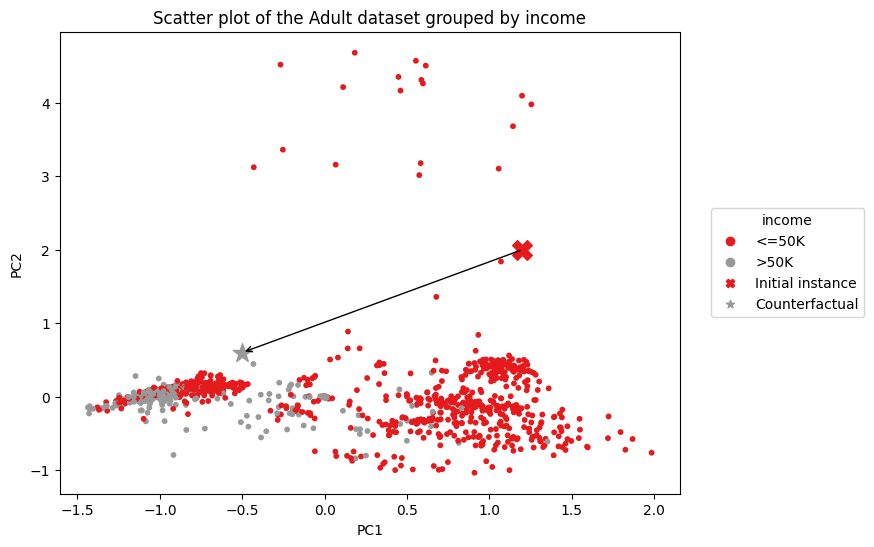

In [16]:
colname = "income"
unique_labels = le_dict[colname].classes_
le_name_mapping = dict(zip(le_dict[colname].classes_, le_dict[colname].transform(le_dict[colname].classes_)))
#         print(le_name_mapping)
# Compare woman, 60+ y.o and people presenting both modalities
zz = np.concatenate(out['zz'])
df_scatter["c"] = train[colname]
df_scatter["label"] = train_original[colname]

# create the second dataframe
df2 = pd.DataFrame({
    'x': [1.2],
    'y': [0],
    'c': [3],
    'label': ['Initial instance']
})

# concatenate the dataframes


# Convert the labels to numeric values
labels, levels = pd.factorize(df_scatter['label'])
levels = list(levels)
# Create a scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(x=df_scatter['x'], y=df_scatter['y'], c=labels, cmap='Set1', s=10, vmin=0, vmax=1)

# Add a title and axis labels
ax.set_title('Scatter plot of the Adult dataset grouped by ' + colname)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

x_init, y_init = 1.2, 2

x_end, y_end = -0.5, 0.6

# Get color map
cmap = matplotlib.colormaps.get_cmap('Set1')
colors = [cmap(i) for i in range(cmap.N)]


#Init
scatter_init = ax.scatter(x=x_init, y=y_init, c=0, cmap='Set1', label="Initial instance", marker="X", s=200, vmin=0, vmax=1)


scatter_end = ax.scatter(x=x_end, y=y_end, c=1, cmap='Set1', label="Counterfactual", marker="*", s=200, vmin=0, vmax=1)

# add an arrow between the points
arrow_props = {'arrowstyle': '->', 'lw': 2, 'color': 'black'}
arrow = ax.annotate('', xy=(x_end, y_end), xytext=(x_init, y_init), arrowprops=dict(arrowstyle='->', color='black'))
arrow.set_visible(True)


# Create a legend
handles, labels = scatter.legend_elements()

handles_init, labels_init = scatter_init.legend_elements()
handles_end, labels_end = scatter_end.legend_elements()

handles = handles + handles_init + handles_end
levels = levels + ["Initial instance", "Counterfactual"]
legend = ax.legend(handles, levels, loc='center left', bbox_to_anchor=(1.05, 0.5), title=colname, borderaxespad=0.)

plt.show()